In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import Model
import tensorflow_probability as tfp
tf.compat.v1.enable_eager_execution()
import matplotlib.pyplot as plt
import gym


# Model

In [ ]:
class PolicyNetwork(Model):
    def __init__(self,num_actions):
        super().__init__()
        self.fc1 = tf.keras.layers.Dense(4,activation='relu')
        self.fc2 = tf.keras.layers.Dense(150,activation='relu')
        self.action = tf.keras.layers.Dense(num_actions,activation='softmax')
        
    def call(self,state):
        x = tf.convert_to_tensor(state)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.action(x)
        return x


# Agent class ( selecting action + storing rewards and nextstate + clacuting loss)

In [ ]:
class Agent:
    def __init__(self,gamma=0.95,learning_rate=0.0009,n_actions=2):
        self.gamma = gamma
        self.lr = learning_rate
        self.model = PolicyNetwork(n_actions)
        self.opt = tf.keras.optimizers.Adam(learning_rate=self.lr)
        self.Collect_actions = []
        self.Collect_rewards = []
        self.Collect_states = []
  
    def select_action(self,state):
        pred = self.model(np.array([state]))
        dist = tfp.distributions.Categorical(probs=pred,dtype=tf.float32)
        action = dist.sample()
        self.Collect_actions.append(action)
        return int(action.numpy()[0])

    def store_reward(self,reward):
        self.Collect_rewards.append(reward)

    def store_state(self,state):
        self.Collect_states.append(state)

    def Training_the_model(self):
        sum_reward = 0
        disc_rewards = []
        self.Collect_rewards.reverse()
        for r in self.Collect_rewards:
            sum_reward = r + self.gamma*sum_reward
            disc_rewards.append(sum_reward)
        disc_rewards.reverse() 
        for state,action,reward in zip(self.Collect_states,self.Collect_actions,disc_rewards):
            with tf.GradientTape() as tape:
                prob_batch = self.model(np.array([state]),training=True)
                loss = self.loss_fn(prob_batch,action,reward)
                grads = tape.gradient(loss,self.model.trainable_variables)
                self.opt.apply_gradients(zip(grads,self.model.trainable_variables))
        self.Collect_rewards = []
        self.Collect_actions = []
        self.Collect_states = []

    def loss_fn(self,prob,action,reward):
        dist = tfp.distributions.Categorical(probs=prob, dtype=tf.float32)
        log_prob = dist.log_prob(action)
        loss = -log_prob*reward
        return loss 


# Calcuting the avg reward till episode 1000 and reward in per episode

In [ ]:
env = gym.make('CartPole-v0')
agent = Agent()
MAX_EPISODES = 1000
episode_score=[]
mean_score=[]
for episod in range(MAX_EPISODES):
    state = env.reset()
    score = 0
    done = False
    while not done:
        action = agent.select_action(state)
        state_,reward,done,info = env.step(action)
        agent.store_reward(reward)
        agent.store_state(state)
        state = state_
        score += reward
        # env.render()
        if done:
            agent.Training_the_model()
            episode_score.append(score)
            mean_score.append(np.mean(episode_score))
            print(f'episode done: {episod+1}\t score recieved: {score}\t avg score recieved: {np.mean(episode_score)}')


episode done: 1	 score recieved: 15.0	 avg score recieved: 15.0
episode done: 2	 score recieved: 12.0	 avg score recieved: 13.5
episode done: 3	 score recieved: 23.0	 avg score recieved: 16.666666666666668
episode done: 4	 score recieved: 20.0	 avg score recieved: 17.5
episode done: 5	 score recieved: 14.0	 avg score recieved: 16.8
episode done: 6	 score recieved: 19.0	 avg score recieved: 17.166666666666668
episode done: 7	 score recieved: 20.0	 avg score recieved: 17.571428571428573
episode done: 8	 score recieved: 20.0	 avg score recieved: 17.875
episode done: 9	 score recieved: 54.0	 avg score recieved: 21.88888888888889
episode done: 10	 score recieved: 56.0	 avg score recieved: 25.3
episode done: 11	 score recieved: 20.0	 avg score recieved: 24.818181818181817
episode done: 12	 score recieved: 16.0	 avg score recieved: 24.083333333333332
episode done: 13	 score recieved: 15.0	 avg score recieved: 23.384615384615383
episode done: 14	 score recieved: 42.0	 avg score recieved: 24.71

# Plotting the avg reward till episode 1000

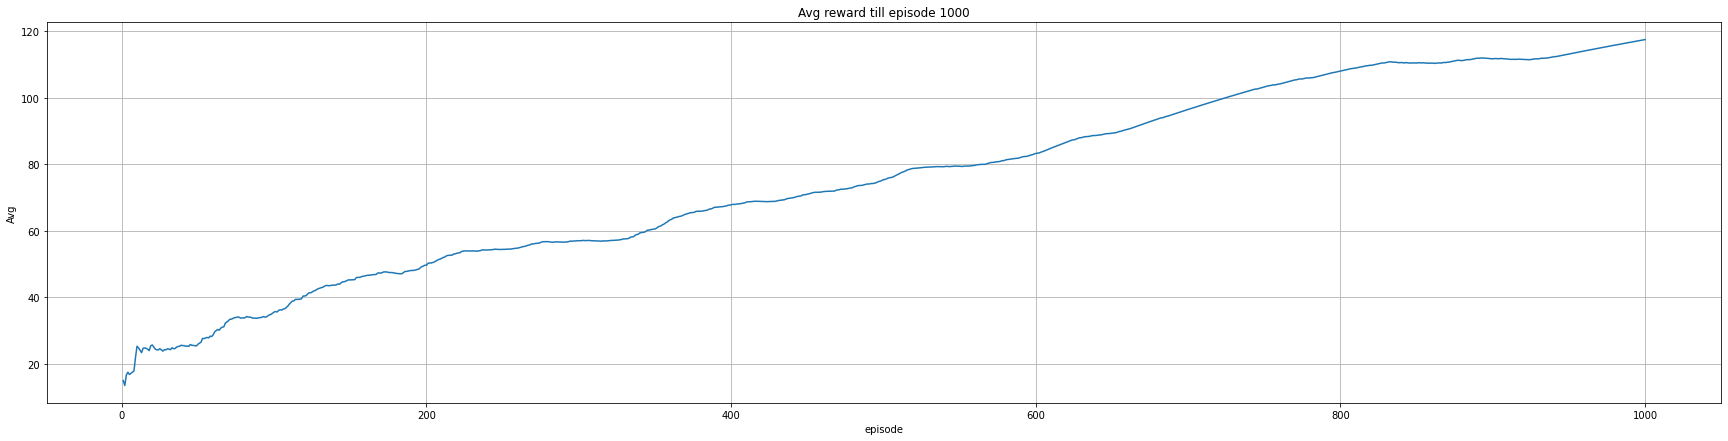

In [ ]:
plt.figure(figsize=(30,7))
k=[ i+1 for i in range(1000)]
plt.plot(k,mean_score)
plt.title('Avg reward till episode 1000')
plt.ylabel('Avg',fontsize=10)
plt.xlabel('episode',fontsize=10)
plt.grid();

#plt.xticks(k);

# Plotting reward in per episode

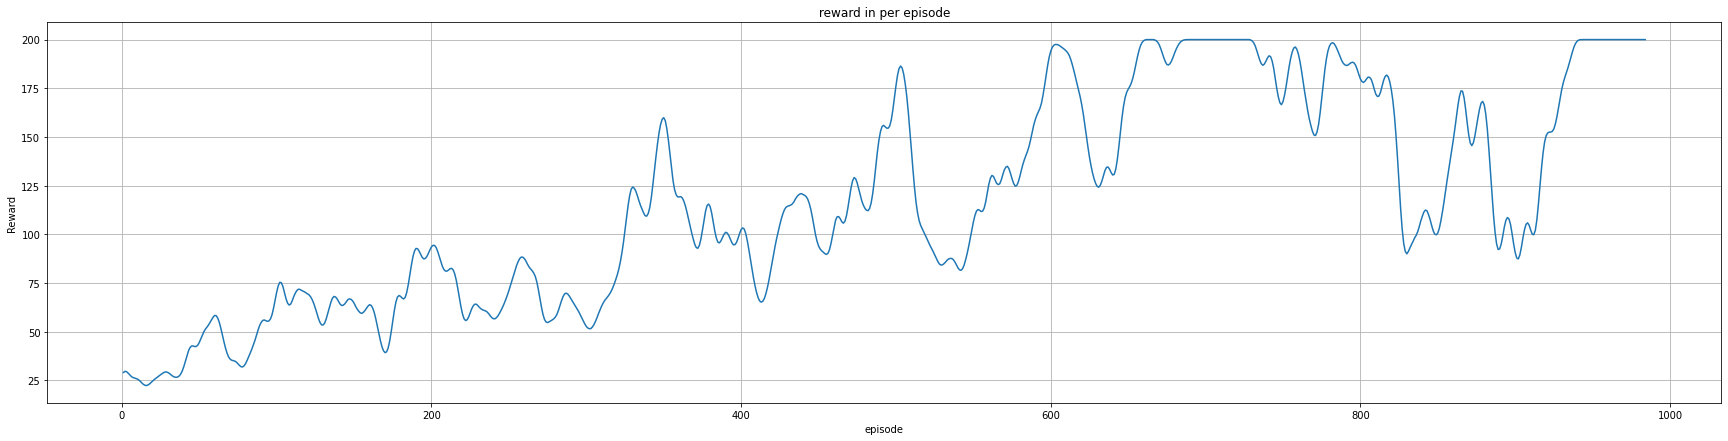

In [ ]:
plt.figure(figsize=(30,7))
k=[ i+1 for i in range(984)]
plt.plot(k,np.convolve(episode_score , np.ones(5)/5, mode='valid'))
plt.title(' reward in per episode ')
plt.ylabel('Reward',fontsize=10)
plt.xlabel('episode',fontsize=10)
plt.grid();